# Quantum Time Series Analysis: Data Generation
Compatible with Qiskit 1.02+

### Author
- **Jacob Cybulski**, jacob.cybulski[at]deakin.edu.au<br/>
    School of IT, SEBE, Deakin University, Melbourne, Vic, Australia

### Date
- October 2022: Prepared for Workshop on Quantum Machine Learning, 13 October 2022, organised in collaboration with QWorld, QPoland, QIndia and Quantum AI Foundation. In association with IEEE Conference Trends in Quantum Computing and Emerging Business Technologies - TQCEBT 2022
- May 2024: Compatibility upgrade to Qiskit 1.02 

### Aims
> *This script aims to create and save a data set.*

In [1]:
import sys
sys.path.append('.')
sys.path.append('..')
sys.path.append('../..')
sys.path.append('../../..')
sys.path

['/home/jacob/miniconda3/envs/qiskit100/lib/python311.zip',
 '/home/jacob/miniconda3/envs/qiskit100/lib/python3.11',
 '/home/jacob/miniconda3/envs/qiskit100/lib/python3.11/lib-dynload',
 '',
 '/home/jacob/miniconda3/envs/qiskit100/lib/python3.11/site-packages',
 '.',
 '..',
 '../..',
 '../../..']

In [2]:
import os
import numpy as np
import pylab
import math
import json
import time
import warnings

from IPython.display import clear_output
from qiskit_algorithms.utils import algorithm_globals

from utils.Target import *
# from utils.Window import *
# from utils.Callback import *
# from utils.TS import *
from utils.Charts import *
# from utils.Integrate import *
# from utils.Circuits import *
# from utils.Angles import *
from utils.Files import *
# from utils.Cost import *
# from utils.Metrics import *

import matplotlib.pyplot as plt
from matplotlib import set_loglevel
set_loglevel("error")
%matplotlib inline

In [3]:
### Listing control
debug = True

### Software version
MAJOR = 8
MINOR = 10

### Constants
LOG_NAME = 'log_1'
CASE_NAME = 'serial'
DATA_NAME = '2_sins'
DATA_PATH = f'{LOG_NAME}/data'
TRAIN_PATH = f'{LOG_NAME}/training'
PARAMS_PATH = f'{LOG_NAME}/params'
ANALYSIS_PATH = f'{LOG_NAME}/analysis'
FIGURES_PATH = f'{LOG_NAME}/figures'

### Show constants
(LOG_NAME, CASE_NAME, DATA_NAME,DATA_PATH, TRAIN_PATH, PARAMS_PATH, ANALYSIS_PATH, FIGURES_PATH)

('log_1',
 'serial',
 '2_sins',
 'log_1/data',
 'log_1/training',
 'log_1/params',
 'log_1/analysis',
 'log_1/figures')

## Utils

## Prepare data
*Values need to be in [0, 1] range*

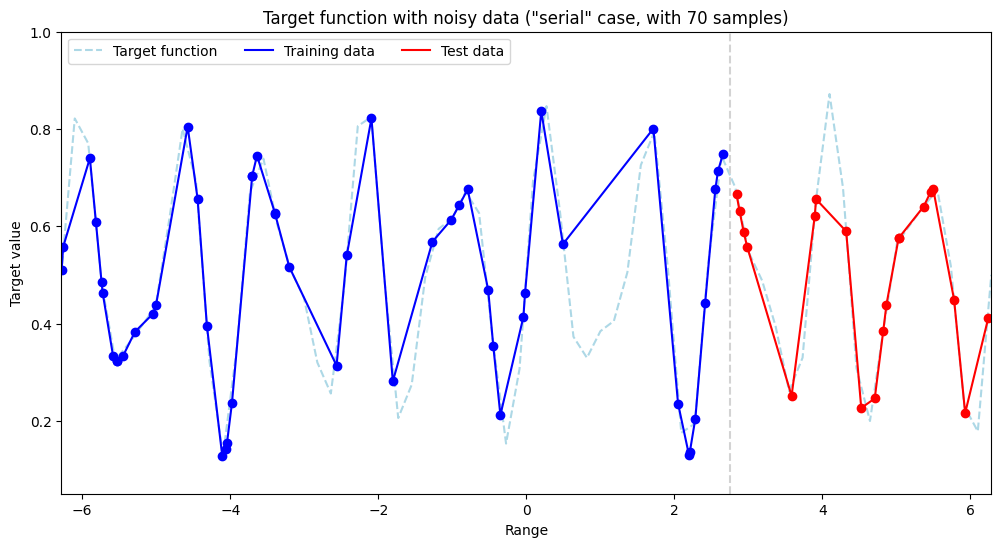

In [4]:
### Start random process

seed = 2022
algorithm_globals.random_seed = 2022

### Data settings
samples_train = 50
samples_valid = 20
samples = samples_train+samples_valid
train_pc = samples_train / samples
noise = 0.0

### Define the time series parameters
#   wind_size: sliding window size (which may be the same as number of qubits)
#   horizon:   the number of time events to look ahead (to forecast)
wind_size = 0
wind_step = 0
horizon = 0

### Select a target class and its parameters (see: utils.py), e.g.
#   Target_sin() # Target_2_sins() # Target_poly() # Target_poly_3()
#   Target_line() # Target_line(slope=0.5, intercept=0.2, xmin=0, xmax=1.5)
#   Target_trig_trend() # Target_jitter()
#   Target_beer() # Target_beer(pt_from=104, pt_to=156)

f = Target_2_sins()

### Collect target function parameters
lb, ub = f.xrange()
lb_train, ub_train = lb, lb+train_pc*(ub - lb)
lb_valid, ub_valid = lb+train_pc*(ub - lb), ub
T   = (ub - lb)

### Prepare all X and y data
X_all   = np.linspace(lb, ub, num=samples)
y_all   = f.fun(X_all)
X_train = (ub_train - lb_train) * algorithm_globals.random.random(samples_train) + lb_train
X_train = np.sort(X_train, axis = 0)
y_train = f.fun(X_train) + noise * (algorithm_globals.random.random(samples_train) - 0.5)
X_valid = (ub_valid - lb_valid) * algorithm_globals.random.random(samples_valid) + lb_valid
X_valid = np.sort(X_valid, axis = 0)
y_valid = f.fun(X_valid) + noise * (algorithm_globals.random.random(samples_valid) - 0.5)

### Reshape Xs for fitting, scoring and prediction
X_all   = X_all.reshape(samples, 1)
X_train = X_train.reshape(samples_train, 1)
X_valid = X_valid.reshape(samples_valid, 1)

### Plot data
plot_train_and_test_data(
    X_all, y_all, X_train, y_train, X_valid, y_valid,
    xlim=(lb, ub), ylim=(0.05, 1),
    colors=['lightblue', 'blue', 'red', 'blue', 'red'], linestyles=['dashed', 'solid', 'solid'],
    title=f'Target function with noisy data ("{CASE_NAME}" case, with {samples} samples)',
    save_plot=f'{FIGURES_PATH}/qtsa_{DATA_NAME}_{CASE_NAME}_fun_and_noise.eps')

In [5]:
print(f'X all: {X_all[0:5]}')
print(f'y all: {y_all[0:5]}')

X all: [[-6.28318531]
 [-6.10106399]
 [-5.91894268]
 [-5.73682137]
 [-5.55470005]]
y all: [0.5        0.82166007 0.7704136  0.48181766 0.32499393]


In [6]:
print(f'X train: {X_train[0:5]}')
print(f'y train: {y_train[0:5]}')

X train: [[-6.27850121]
 [-6.25734171]
 [-5.89671695]
 [-5.81518432]
 [-5.73868381]]
y train: [0.51053758 0.55787456 0.74006597 0.60878606 0.48458537]


## Save training data

In [7]:
### All created files have the following codes:
#   t: training sample size
#   v: validation sample size
#   z: level of noise injected
#   w: window size
#   s: window step size
#   h: horizon size
DATA_PREF = f'{DATA_NAME}_t{samples_train}_v{samples_valid}_z{noise}_w{wind_size}_s{wind_step}_h{horizon}'
DATA_PREF

'2_sins_t50_v20_z0.0_w0_s0_h0'

In [8]:
### Define file names

x_all_fpath = f'{DATA_PATH}/{DATA_PREF}_x_all.arr'
y_all_fpath = f'{DATA_PATH}/{DATA_PREF}_y_all.arr'

x_train_fpath = f'{DATA_PATH}/{DATA_PREF}_x_train.arr'
y_train_fpath = f'{DATA_PATH}/{DATA_PREF}_y_train.arr'
x_valid_fpath = f'{DATA_PATH}/{DATA_PREF}_x_valid.arr'
y_valid_fpath = f'{DATA_PATH}/{DATA_PREF}_y_valid.arr'

data_info_fpath = f'{DATA_PATH}/{DATA_PREF}_info.json'
data_info_fpath

'log_1/data/2_sins_t50_v20_z0.0_w0_s0_h0_info.json'

In [9]:
## Save training parameters
### Save info details
data_info = \
    {'data_name':DATA_NAME, 
     'major_version':MAJOR, 
     'minor_version':MINOR,
     'data_train':samples_train,
     'data_valid':samples_valid,
     'data_noise':noise,
     'wind_size':wind_size,
     'wind_step':wind_step,
     'wind_horizon':horizon,
     'seed':seed}

### Saving the info file
write_json_file(data_info_fpath, data_info)
    
print(f'\nSaved time series info in file "{data_info_fpath}":\n')
for k in data_info.keys():
    print(f'\tinfo[{k}] = {data_info[k]}')
print()


Saved time series info in file "log_1/data/2_sins_t50_v20_z0.0_w0_s0_h0_info.json":

	info[data_name] = 2_sins
	info[major_version] = 8
	info[minor_version] = 10
	info[data_train] = 50
	info[data_valid] = 20
	info[data_noise] = 0.0
	info[wind_size] = 0
	info[wind_step] = 0
	info[wind_horizon] = 0
	info[seed] = 2022



In [10]:
### Save the history file
write_ts_file(x_all_fpath, X_all)
write_ts_file(y_all_fpath, y_all)
write_ts_file(x_train_fpath, X_train)
write_ts_file(y_train_fpath, y_train)
write_ts_file(x_valid_fpath, X_valid)
write_ts_file(y_valid_fpath, y_valid)
print(f'\nSaved time series data\n')


Saved time series data



## System details

In [11]:
!pip list | grep -e qiskit -e torch

qiskit                        1.0.2
qiskit-aer-gpu                0.14.1
qiskit-algorithms             0.3.0
qiskit-finance                0.4.1
qiskit-machine-learning       0.7.2
qiskit-nature                 0.7.2
qiskit-optimization           0.6.1
qiskit-qasm3-import           0.4.2
torch                         2.3.0
torchaudio                    2.3.0
torchsummary                  1.5.1
torchvision                   0.18.0
